## STEP 1: IMPORT LIBRARIES

In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import warnings
from pathlib import Path

import numpy.random as random
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix




## STEP 2: LOAD DATA AND UNDERSTAND THE PROBLEM

In [ ]:
# Load Data
train_data_insurance = pd.read_csv('insurance_3_TRAINING.csv')
score_data_insurance = pd.read_csv('insurance_3_SCORE.csv')

print(f"Train Data (Insurance): {train_data_insurance.shape[0]} rows, {train_data_insurance.shape[1]} columns")
print(f"Score Data (Insurance): {score_data_insurance.shape[0]} rows, {score_data_insurance.shape[1]} columns")

Train Data (Insurance): 20460 rows, 12 columns
Score Data (Insurance): 2000 rows, 11 columns


In [645]:
train_data_insurance.head()

,id_new,buy,age,gender,tenure,region,dl,has_v_insurance,v_age,v_accident,v_prem_quote,cs_rep
0,a00000000,0,34,female,31,19,1,0,1-2 year,yes,27715.0,154
1,a00000001,0,50,male,211,34,1,0,1-2 year,yes,33945.0,154
2,a00000002,0,42,female,122,29,1,0,1-2 year,yes,37577.0,163
3,a00000003,0,28,male,75,3,1,0,1-2 year,yes,2630.0,154
4,a00000004,0,75,female,19,28,1,0,1-2 year,yes,47511.0,122


In [646]:
# Data Type Info
print("Data Types:")
print(train_data_insurance.dtypes)

# Check Missing Values
print("\nMissing Values:")
print(train_data_insurance.isnull().sum())

# Check Duplicates
print(f"\nDuplicate Rows: {train_data_insurance.duplicated().sum()}")


Data Types:
id_new              object
buy                  int64
age                  int64
gender              object
tenure               int64
region               int64
dl                   int64
has_v_insurance      int64
v_age               object
v_accident          object
v_prem_quote       float64
cs_rep               int64
dtype: object

Missing Values:
id_new             0
buy                0
age                0
gender             0
tenure             0
region             0
dl                 0
has_v_insurance    0
v_age              0
v_accident         0
v_prem_quote       0
cs_rep             0
dtype: int64

Duplicate Rows: 0


#### **Conclusion**: No Missing values or Duplicates found


In [647]:
print(train_data_insurance.nunique())

id_new             20460
buy                    2
age                   65
gender                 2
tenure               290
region                53
dl                     2
has_v_insurance        2
v_age                  3
v_accident             2
v_prem_quote       13104
cs_rep                 4
dtype: int64


#### Observation: region is a high cardinality class, target encoding maybe nessecary.

##  STEP 3: EXPLORE TARGET COLUMN (buy)


Target Variable (buy) Distribution:
DIDN'T Buy (0): 16705 customers (81.65%)
DID Buy (1): 3755 customers (18.35%)

Imbalance Ratio: 4.45:1


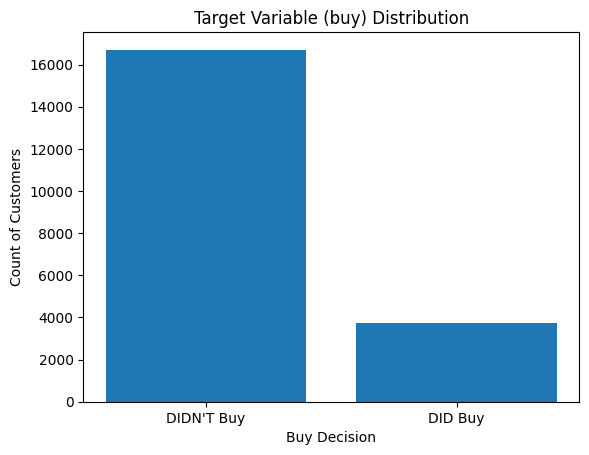

In [648]:
# "buy" column analysis
target_counts_insurance = train_data_insurance['buy'].value_counts()
target_percentage_insurance = train_data_insurance['buy'].value_counts(normalize=True) * 100

print("\nTarget Variable (buy) Distribution:")
print(f"DIDN'T Buy (0): {target_counts_insurance[0]} customers ({target_percentage_insurance[0]:.2f}%)")
print(f"DID Buy (1): {target_counts_insurance[1]} customers ({target_percentage_insurance[1]:.2f}%)")


# Imbalance ratio (DIDN'T Buy vs DID Buy)
print(f"\nImbalance Ratio: {target_percentage_insurance[0]/target_percentage_insurance[1]:.2f}:1")
plt.figure()
bars = plt.bar(["DIDN'T Buy", "DID Buy"], target_counts_insurance.values)
plt.title('Target Variable (buy) Distribution')
plt.ylabel('Count of Customers')
plt.xlabel('Buy Decision')
plt.show()


#### **Findings**:
#### This is a SEVERE CLASS IMBALANCE problem
#### Problem: Only 18.35% customers buy insurance.
#### Solution: We should use class_weight='balanced'

## STEP 4: EXPLORE NUMERICAL COLUMNS

In [649]:
# List the numerical columns
numerical_cols_insurance = ['age', 'tenure', 'v_prem_quote', 'region', 'dl', 'has_v_insurance', 'cs_rep']


print("\nSummary:")
train_data_insurance[numerical_cols_insurance].describe()


Summary:


,age,tenure,v_prem_quote,region,dl,has_v_insurance,cs_rep
count,20460.000000,20460.000000,20460.000000,20460.000000,20460.000000,20460.000000,20460.000000
mean,42.512317,152.908016,31689.197361,26.624878,0.996970,0.276540,140.588759
std,15.615623,83.483286,18757.868023,11.568606,0.054966,0.447298,16.749921
min,20.000000,10.000000,2630.000000,0.000000,0.000000,0.000000,122.000000
25%,29.000000,81.000000,24731.750000,24.000000,1.000000,0.000000,122.000000
50%,40.000000,151.000000,32533.500000,28.000000,1.000000,0.000000,151.000000
75%,53.000000,225.250000,41294.250000,29.000000,1.000000,1.000000,154.000000
max,85.000000,299.000000,472042.000000,52.000000,1.000000,1.000000,163.000000


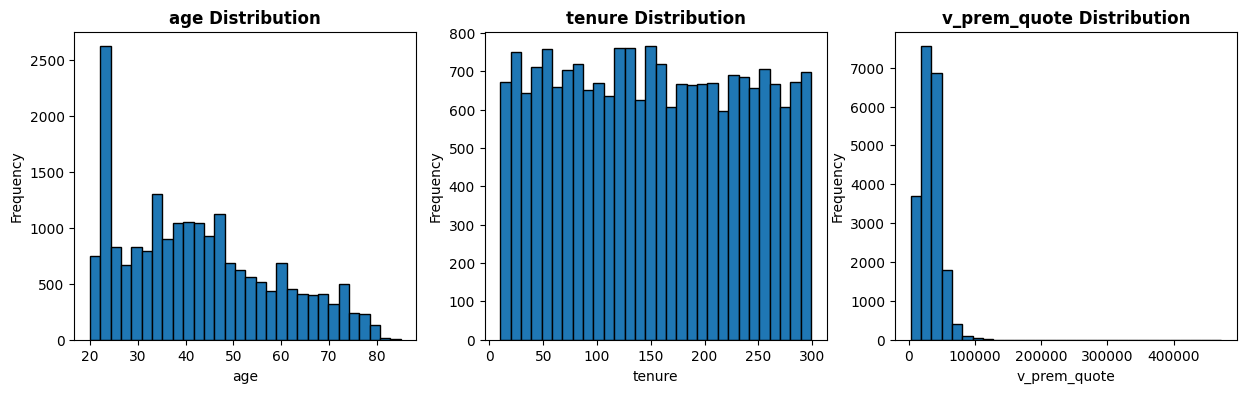

In [650]:
# Some numerical cols for visualization 
main_numerical_insurance = ['age', 'tenure', 'v_prem_quote']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(main_numerical_insurance):
    axes[i].hist(train_data_insurance[col], bins=30, edgecolor='black')
    axes[i].set_title(f'{col} Distribution', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.show()



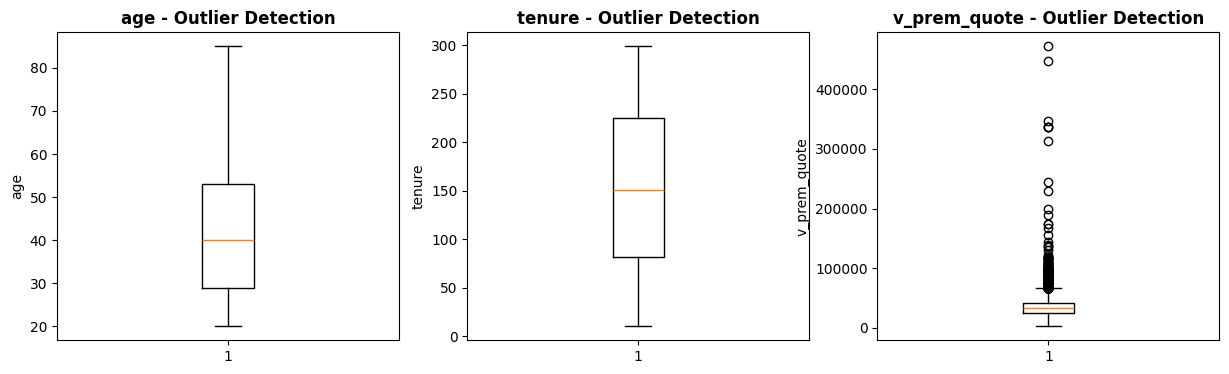

In [651]:
# Outlier Checks
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(main_numerical_insurance):
    axes[i].boxplot(train_data_insurance[col])
    axes[i].set_title(f'{col} - Outlier Detection', fontweight='bold')
    axes[i].set_ylabel(col)
plt.show()


#### We will have to handle some extreme values from v_prem_quote as it can heavily affect our model

In [652]:
# Detailed outlier analysis (v_prem_quote)
Q1 = train_data_insurance['v_prem_quote'].quantile(0.25)
Q3 = train_data_insurance['v_prem_quote'].quantile(0.75)

# Inter Quartile Range method (to find outliers)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_v_prem_quote = train_data_insurance[(train_data_insurance['v_prem_quote'] < lower_bound) | (train_data_insurance['v_prem_quote'] > upper_bound)]

print(f"\nOutliers in Premium Quotes (v_prem_quote):")
print(f"  Found: {len(outliers_v_prem_quote)} outliers ({len(outliers_v_prem_quote)/len(train_data_insurance)*100:.2f}% of data)")
print(f"  Normal range: ${lower_bound:.2f} to ${upper_bound:.2f}")
print(f"  Max value: ${train_data_insurance['v_prem_quote'].max():.2f}")






Outliers in Premium Quotes (v_prem_quote):
  Found: 524 outliers (2.56% of data)
  Normal range: $-112.00 to $66138.00
  Max value: $472042.00


#### We will CAP outliers at upper bound (not remove them)
#### REASON: very large premium quotes are likely valid business cases (not data entry errors). Capping reduces their undue influence on models while keeping those rows.

## STEP 5: EXPLORE CATEGORICAL FEATURES


gender: ['female' 'male']
gender
male      11314
female     9146
Name: count, dtype: int64

v_age: ['1-2 year' '< 1 year' '> 2 years']
v_age
1-2 year     13878
< 1 year      5165
> 2 years     1417
Name: count, dtype: int64

v_accident: ['yes' 'no']
v_accident
yes    13968
no      6492
Name: count, dtype: int64


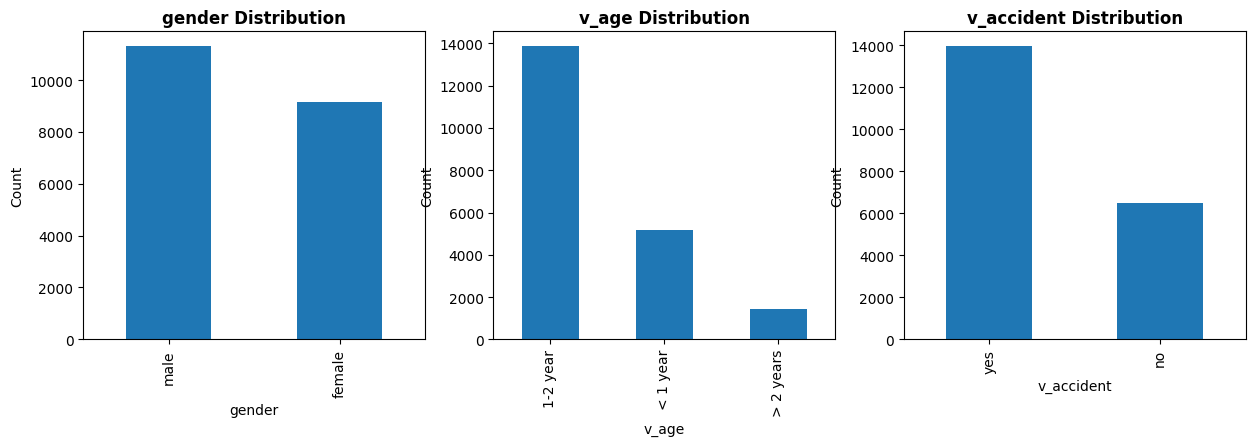


Special Categorical Features (unique values):
  region: 53 (Too many)
  cs_rep: 4


In [653]:

categorical_cols = ['gender', 'v_age', 'v_accident']

# list unique values for each categorical attribute
for col in categorical_cols:
    print(f"\n{col}: {train_data_insurance[col].unique()}")
    print(train_data_insurance[col].value_counts())


# Visualize 
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(categorical_cols):
    train_data_insurance[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} Distribution', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
plt.show()

# Check region and cs_rep (these need special handling)
print(f"\nSpecial Categorical Features (unique values):")
print(f"  region: {train_data_insurance['region'].nunique()} (Too many)")
print(f"  cs_rep: {train_data_insurance['cs_rep'].nunique()}")




#### DECISION: region has 53 unique values - we'll use TARGET ENCODING
#### REASON: Creating 53 dummy variables would increase the dimentions drastically.

## STEP 6: DATA PREPROCESSING

### Feature engineering

In [654]:
train_processed_insurance = train_data_insurance.copy()
score_processed_insurance = score_data_insurance.copy()

In [655]:
# Cap extreme values at upper bound (v_prem_quote)
print("Handle Outliers in Premium Quotes")
train_processed_insurance['v_prem_quote'] = np.where(train_processed_insurance['v_prem_quote'] > upper_bound, upper_bound, train_processed_insurance['v_prem_quote'])
score_processed_insurance['v_prem_quote'] = np.where(score_processed_insurance['v_prem_quote'] > upper_bound, upper_bound, score_processed_insurance['v_prem_quote'])
print("Capped premium quotes at ${}".format(upper_bound))

Handle Outliers in Premium Quotes
Capped premium quotes at $66138.0


In [656]:
# Cap extreme values at upper bound (v_prem_quote)
print("Handle Outliers in Premium Quotes")
train_processed_insurance['v_prem_quote'] = np.where(train_processed_insurance['v_prem_quote'] > upper_bound, upper_bound, train_processed_insurance['v_prem_quote'])
score_processed_insurance['v_prem_quote'] = np.where(score_processed_insurance['v_prem_quote'] > upper_bound, upper_bound, score_processed_insurance['v_prem_quote'])
print("Capped premium quotes at ${}".format(upper_bound))

Handle Outliers in Premium Quotes
Capped premium quotes at $66138.0


In [657]:
print("One-Hot Encoding v_age (vehicle age)")
# Create dummy columns for '< 1 year', '1-2 year', '> 2 years'
train_processed_insurance = pd.get_dummies(train_processed_insurance, columns=['v_age'], drop_first=True)
score_processed_insurance = pd.get_dummies(score_processed_insurance, columns=['v_age'], drop_first=True)
print("Created dummy columns for vehicle age")

One-Hot Encoding v_age (vehicle age)
Created dummy columns for vehicle age


In [658]:
print("Target Encoding of region attribute (53 unique values)")
# For each region-> calculate average purchase rate
# This converts region code to a meaningful number
region_target_mean = train_processed_insurance.groupby('region')['buy'].mean()
train_processed_insurance['region_encoded'] = train_processed_insurance['region'].map(region_target_mean)
score_processed_insurance['region_encoded'] = score_processed_insurance['region'].map(region_target_mean).fillna(region_target_mean.mean())
train_processed_insurance.drop('region', axis=1, inplace=True)
score_processed_insurance.drop('region', axis=1, inplace=True)
print("Converted region to purchase rate encoding")

Target Encoding of region attribute (53 unique values)
Converted region to purchase rate encoding


In [659]:
print("One-Hot Encoding cs_rep (customer service rep)")
# Only 4 unique values, safe to create dummy columns
train_processed_insurance = pd.get_dummies(train_processed_insurance, columns=['cs_rep'], prefix='cs_rep', drop_first=True)

print("Created dummy columns for customer service rep")
score_processed_insurance = pd.get_dummies(score_processed_insurance, columns=['cs_rep'], prefix='cs_rep', drop_first=True)

One-Hot Encoding cs_rep (customer service rep)
Created dummy columns for customer service rep


In [660]:
# Clean column names
# Remove special characters from column names to avoid errors (some libraries dont support '<')
train_processed_insurance.rename(columns={'v_age_< 1 year': 'v_age_less_1_year', 'v_age_> 2 years': 'v_age_more_2_years'}, inplace=True)
score_processed_insurance.rename(columns={'v_age_< 1 year': 'v_age_less_1_year', 'v_age_> 2 years': 'v_age_more_2_years'}, inplace=True)
print("Removed special characters from column names")

Removed special characters from column names


In [661]:
# Create age bins for train df
train_processed_insurance['age_group'] = pd.cut(train_processed_insurance['age'], 
                                bins=[0, 25, 40, 65, 100], 
                                labels=['18-25', '26-40', '41-65', '65+'])

# Create age bins for score df
score_processed_insurance['age_group'] = pd.cut(score_processed_insurance['age'], 
                               bins=[0, 25, 40, 65, 100], 
                               labels=['18-25', '26-40', '41-65', '65+'])

# Drop the original 'age' column from both datasets
train_processed_insurance.drop('age', axis=1, inplace=True)
score_processed_insurance.drop('age', axis=1, inplace=True)

# Ensure 'age_group' is categorical
train_processed_insurance['age_group'] = train_processed_insurance['age_group'].astype('category')
score_processed_insurance['age_group'] = score_processed_insurance['age_group'].astype('category')

print("Age binning completed for both train and test datasets")
print("Original 'age' column has been dropped")
print("Dtype of age_group (train):", train_processed_insurance['age_group'].dtype)
print("Dtype of age_group (test):", score_processed_insurance['age_group'].dtype)
print("\nAge group distribution in train set:")
print(train_processed_insurance['age_group'].value_counts().sort_index())
print("\nAge group distribution in test set:")
print(score_processed_insurance['age_group'].value_counts().sort_index())

Age binning completed for both train and test datasets
Original 'age' column has been dropped
Dtype of age_group (train): category
Dtype of age_group (test): category

Age group distribution in train set:
age_group
18-25    3853
26-40    6405
41-65    7957
65+      2245
Name: count, dtype: int64

Age group distribution in test set:
age_group
18-25    379
26-40    617
41-65    801
65+      203
Name: count, dtype: int64


In [662]:
print("One-Hot Encoding age_group")
# Only 4 unique values, safe to create dummy columns
train_processed_insurance = pd.get_dummies(train_processed_insurance, columns=['age_group'], prefix='age_group', drop_first=True)

print("Created dummy columns for age_group")
score_processed_insurance = pd.get_dummies(score_processed_insurance, columns=['age_group'], prefix='age_group', drop_first=True)

One-Hot Encoding age_group
Created dummy columns for age_group


In [663]:
# Simplified tenure quartile binning (drop original 'tenure' afterward)

print("Binning tenure into quartiles and dropping original 'tenure'")

# Remove any previously created tenure_bin_* columns (from earlier cell runs)
for df in (train_processed_insurance, score_processed_insurance):
    tenure_cols = [c for c in df.columns if c.startswith('tenure_bin_')]
    if tenure_cols:
        df.drop(columns=tenure_cols, inplace=True)

# Compute quartile edges on training data
edges = np.quantile(train_processed_insurance['tenure'], [0, 0.25, 0.50, 0.75, 1.0])

# Ensure strictly increasing (handle possible duplicate quantiles)
for i in range(1, len(edges)):
    if edges[i] <= edges[i - 1]:
        edges[i] = edges[i - 1] + 1e-6

labels = ['Q1', 'Q2', 'Q3', 'Q4']

# Bin tenure
train_bins = pd.cut(train_processed_insurance['tenure'], edges, labels=labels, include_lowest=True)
score_bins = pd.cut(score_processed_insurance['tenure'], edges, labels=labels, include_lowest=True)

print("Train tenure bin counts:")
print(train_bins.value_counts().sort_index())
print("Score tenure bin counts:")
print(score_bins.value_counts().sort_index())

# One-hot encode (drop_first=True)
train_dummies = pd.get_dummies(train_bins, prefix='tenure_bin', drop_first=True)
score_dummies = pd.get_dummies(score_bins, prefix='tenure_bin', drop_first=True)

# Align columns
score_dummies = score_dummies.reindex(columns=train_dummies.columns, fill_value=0)

# Concat
train_processed_insurance = pd.concat([train_processed_insurance, train_dummies.astype(int)], axis=1)
score_processed_insurance = pd.concat([score_processed_insurance, score_dummies.astype(int)], axis=1)

# Drop original 'tenure'
train_processed_insurance.drop(columns='tenure', inplace=True)
score_processed_insurance.drop(columns='tenure', inplace=True)

print("Added tenure_bin dummies:", list(train_dummies.columns))
print("Dropped original 'tenure'. Bin edges:", edges.tolist())


Binning tenure into quartiles and dropping original 'tenure'
Train tenure bin counts:
tenure
Q1    5176
Q2    5079
Q3    5090
Q4    5115
Name: count, dtype: int64
Score tenure bin counts:
tenure
Q1    507
Q2    447
Q3    551
Q4    495
Name: count, dtype: int64
Added tenure_bin dummies: ['tenure_bin_Q2', 'tenure_bin_Q3', 'tenure_bin_Q4']
Dropped original 'tenure'. Bin edges: [10.0, 81.0, 151.0, 225.25, 299.0]


In [664]:
print("Label Encoding Binary Features (gender, v_accident, 'cs_rep_151', 'cs_rep_154', 'cs_rep_163', 'v_age_less_1_year', 'v_age_more_2_years', 'age_group_41-65', 'age_group_26-40', 'age_group_65+')")
# Convert text to numbers: 'male'->1, 'female'->0, 'yes'->1, 'no'->0
le = LabelEncoder()
for col in ['gender', 'v_accident', 'cs_rep_151', 'cs_rep_154', 'cs_rep_163', 'v_age_less_1_year', 'v_age_more_2_years', 'age_group_26-40', 'age_group_41-65', 'age_group_65+']:
    train_processed_insurance[col] = le.fit_transform(train_processed_insurance[col])
    score_processed_insurance[col] = le.transform(score_processed_insurance[col])

Label Encoding Binary Features (gender, v_accident, 'cs_rep_151', 'cs_rep_154', 'cs_rep_163', 'v_age_less_1_year', 'v_age_more_2_years', 'age_group_41-65', 'age_group_26-40', 'age_group_65+')


In [665]:
#sanity check
train_processed_insurance.head()

,id_new,buy,gender,dl,has_v_insurance,v_accident,v_prem_quote,v_age_less_1_year,v_age_more_2_years,region_encoded,cs_rep_151,cs_rep_154,cs_rep_163,age_group_26-40,age_group_41-65,age_group_65+,tenure_bin_Q2,tenure_bin_Q3,tenure_bin_Q4
0,a00000000,0,0,1,0,1,27715.0,0,0,0.215385,0,1,0,1,0,0,0,0,0
1,a00000001,0,1,1,0,1,33945.0,0,0,0.131579,0,1,0,0,1,0,0,1,0
2,a00000002,0,0,1,0,1,37577.0,0,0,0.244344,0,0,1,0,1,0,1,0,0
3,a00000003,0,1,1,0,1,2630.0,0,0,0.263158,0,1,0,1,0,0,0,0,0
4,a00000004,0,0,1,0,1,47511.0,0,0,0.200084,0,0,0,0,0,1,0,0,0


### Data pre-processing (prepare Y data)

In [666]:
np.random.seed(10)
random_state = 10

In [ ]:
# y for train data
target_insurance= pd.get_dummies(train_processed_insurance['buy'], drop_first=False)
target_insurance = target_insurance[[0, 1]]

### Re-process X data

In [ ]:
X_train = train_processed_insurance.drop(columns=['buy','id_new'])
X_score = score_processed_insurance.drop(columns=['id_new'])

### Normalize/Scale the data

In [669]:
print("Scale numerical features")
# Convert all numbers to same scale (necessary for SVM, KNN, Neural Networks)
scaler = StandardScaler()
col_to_scale = ['v_prem_quote', 'region_encoded']
X_train[col_to_scale] = scaler.fit_transform(X_train[col_to_scale])
X_score[col_to_scale] = scaler.transform(X_score[col_to_scale])
print("Scaled features to mean=0, std=1")

Scale numerical features
Scaled features to mean=0, std=1


In [670]:
# Preprocessing Complete (Final Features and Target ready)
print(f"Final Features: {X_train.shape[1]} columns")
print(f"Feature Names: {list(X_train.columns)}")

Final Features: 17 columns
Feature Names: ['gender', 'dl', 'has_v_insurance', 'v_accident', 'v_prem_quote', 'v_age_less_1_year', 'v_age_more_2_years', 'region_encoded', 'cs_rep_151', 'cs_rep_154', 'cs_rep_163', 'age_group_26-40', 'age_group_41-65', 'age_group_65+', 'tenure_bin_Q2', 'tenure_bin_Q3', 'tenure_bin_Q4']


In [671]:
X_train.head()

,gender,dl,has_v_insurance,v_accident,v_prem_quote,v_age_less_1_year,v_age_more_2_years,region_encoded,cs_rep_151,cs_rep_154,cs_rep_163,age_group_26-40,age_group_41-65,age_group_65+,tenure_bin_Q2,tenure_bin_Q3,tenure_bin_Q4
0,0,1,0,1,-0.213076,0,0,0.787137,0,1,0,1,0,0,0,0,0
1,1,1,0,1,0.163431,0,0,-1.283651,0,1,0,0,1,0,0,1,0
2,0,1,0,1,0.382928,0,0,1.502704,0,0,1,0,1,0,1,0,0
3,1,1,0,1,-1.729072,0,0,1.967587,0,1,0,1,0,0,0,0,0
4,0,1,0,1,0.983284,0,0,0.409079,0,0,0,0,0,1,0,0,0


In [672]:
X_score.head()

,gender,dl,has_v_insurance,v_accident,v_prem_quote,v_age_less_1_year,v_age_more_2_years,region_encoded,cs_rep_151,cs_rep_154,cs_rep_163,age_group_26-40,age_group_41-65,age_group_65+,tenure_bin_Q2,tenure_bin_Q3,tenure_bin_Q4
0,1,1,0,1,-0.303062,0,0,0.537042,0,0,1,0,1,0,1,0,0
1,0,1,0,1,0.805183,1,0,0.291433,0,1,0,0,0,0,0,0,1
2,1,1,1,0,-0.026877,0,0,0.409079,0,0,0,0,1,0,1,0,0
3,0,1,0,1,0.267620,0,0,-1.134512,0,0,1,1,0,0,0,0,1
4,1,1,0,1,0.048243,0,0,0.409079,0,0,0,0,1,0,1,0,0


## STEP 7: CORRELATION ANALYSIS

In [341]:
# Analyse which features is important
numeric_features_insurance = train_processed_insurance.select_dtypes(include=['number'])
correlations_insurance = numeric_features_insurance.corr()['buy'].sort_values(ascending=False)

print("\nCorrelations with Target (buy):")
print(correlations_insurance)


Correlations with Target (buy):
buy                   1.000000
v_accident            0.301250
cs_rep_163            0.112020
age_group_26-40       0.109044
region_encoded        0.104548
cs_rep_154            0.095157
age_group_41-65       0.045496
gender                0.033409
dl                    0.016950
v_age_more_2_years    0.016878
tenure_bin_Q3         0.004334
tenure_bin_Q2         0.002296
v_prem_quote          0.002000
tenure_bin_Q4        -0.001093
age_group_65+        -0.069089
v_age_less_1_year    -0.120307
cs_rep_151           -0.179770
has_v_insurance      -0.287762
Name: buy, dtype: float64


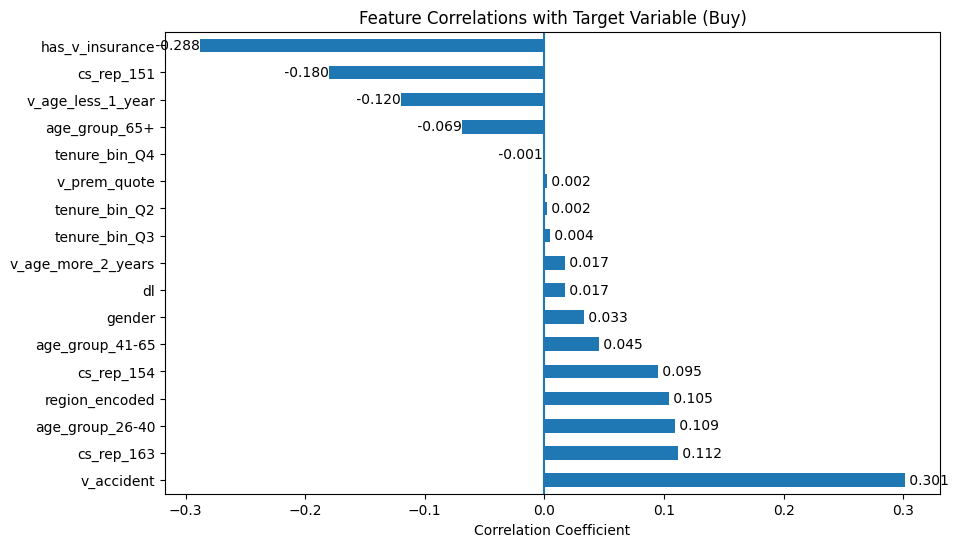

In [342]:
# Visualize correlations
plt.figure(figsize=(10, 6))
bars = correlations_insurance.drop('buy').plot(kind='barh')
plt.title('Feature Correlations with Target Variable (Buy)')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0)

# Add correlation values on bars
for i, (feature, value) in enumerate(correlations_insurance.drop('buy').items()):
    plt.text(value, i, f' {value:.3f}', va='center', ha='left' if value > 0 else 'right')

plt.show()

#### Correlation Analysis:
#####   has_v_insurance: -0.29 (STRONG negative -> already insured = less likely to buy)
#####   v_accident: -0.30 (STRONG negative -> more accidents = less likely to buy)

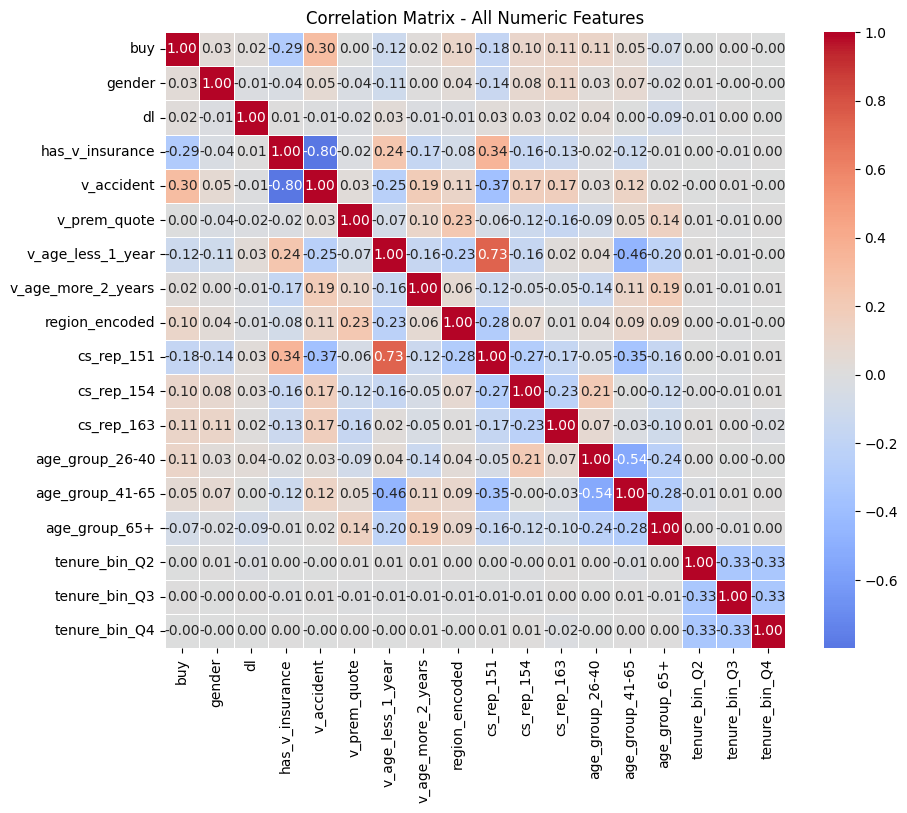

In [343]:
# Full correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_features_insurance.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)
plt.title('Correlation Matrix - All Numeric Features')
plt.show()

#### Checking for multicolinearity:
 The strongest correlation between any two independent features is found between: has_v_insurance and v_accident. The correlation coefficient for this pair is -0.80.

 Regularization methods maybe necessary to mitigate the effects of multicollinearity for linear models (Multiple Linear Regression, Logistic Regression, etc). 

## STEP 8: SPLIT DATA


In [673]:
# Split data: 60% for training, 40% for testing
# stratify=y: ensures both sets have same class proportion (18% buy rate)
features_train_insurance, features_test_insurance, target_train_insurance, target_test_insurance = train_test_split(
    X_train, target_insurance, test_size=0.4, random_state=42, stratify=target_insurance
)

print(f"\nTraining Set: {features_train_insurance.shape[0]} samples")
print(f"Testing Set: {features_test_insurance.shape[0]} samples")

print(f"\n\nBuy Rate in Training: {target_train_insurance[1].mean()*100:.2f}%")
print(f"Buy Rate in Testing: {target_test_insurance[1].mean()*100:.2f}%")
print("\nBoth sets maintain 18.35% purchase rate (stratified split)")



Training Set: 12276 samples
Testing Set: 8184 samples


Buy Rate in Training: 18.35%
Buy Rate in Testing: 18.35%

Both sets maintain 18.35% purchase rate (stratified split)


## STEP 9: TRAIN MULTIPLE MODELS


In [350]:
# class weight calculation for imbalanced insurance data
# Tells models to pay more attention to minority class (buy=1)

# Convert one-hot DataFrame y (columns 0 and 1) to a 1D label array (0/1)
y_train_labels = target_train_insurance[1].astype(int).to_numpy()

# Compute scale_pos_wt correctly: (# negatives / # positives)
neg_count = (y_train_labels == 0).sum()
pos_count = (y_train_labels == 1).sum()
scale_pos_wt = neg_count / pos_count

# Compute balanced class weights
class_wt_arr = compute_class_weight(class_weight='balanced',
									classes=np.array([0, 1]),
									y=y_train_labels)
class_wt_dict = {0: class_wt_arr[0], 1: class_wt_arr[1]}

print(f"\nClass Weight Calculation:")
print(f"Scale Pos Wt: {scale_pos_wt:.2f}")
print(f"This means: Give {scale_pos_wt:.2f}x more importance to 'buy=1' class")
print(f"Class Weights (sklearn format): {class_wt_dict}")


Class Weight Calculation:
Scale Pos Wt: 4.45
This means: Give 4.45x more importance to 'buy=1' class
Class Weights (sklearn format): {0: np.float64(0.6123914995510327), 1: np.float64(2.7243675099866844)}


using weight is important to stop model for classifying all the results as majority class

In [351]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        class_weight='balanced',  # Automatically adjusts for imbalance
        max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42, 
        class_weight='balanced', # Automatically adjusts for imbalance
        n_estimators=100
    ),
    'XGBoost': XGBClassifier(
        random_state=42, 
        scale_pos_weight=scale_pos_wt,  # XGBoost's way of handling imbalance
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    'SVM': SVC(
        random_state=42, 
        class_weight='balanced', # Automatically adjusts for imbalance 
        probability=True,  # Needed for probability predictions
        kernel='rbf'
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5
        # KNN doesn't have class_weight parameter
    ),
    'LightGBM': LGBMClassifier(
        random_state=42, 
        scale_pos_weight=scale_pos_wt,  # LightGBM's way of handling imbalance
        n_estimators=100,
        verbose=-1  # Suppress warnings
    )
}


In [353]:
# Store all results for comparison
model_results = {}

# Stratified K-Fold: ensures each fold maintains class proportions
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nTraining models 5 times on different data splits")

# Use 1D label vectors (already created earlier: y_train_labels). Create test 1D labels.
y_test_labels = target_test_insurance[1].astype(int).to_numpy()

# Train and evaluate each model
for model_name, model in models.items():
    print(f"{'='*56}")
    print(f"Training: {model_name}")
    print(f"{'='*56}")
    
    # Cross-validation with 1D labels
    cv_auc = cross_val_score(model, features_train_insurance, y_train_labels, cv=skf, scoring='roc_auc')
    cv_f1 = cross_val_score(model, features_train_insurance, y_train_labels, cv=skf, scoring='f1')
    cv_accuracy = cross_val_score(model, features_train_insurance, y_train_labels, cv=skf, scoring='accuracy')
    cv_precision = cross_val_score(model, features_train_insurance, y_train_labels, cv=skf, scoring='precision')
    cv_recall = cross_val_score(model, features_train_insurance, y_train_labels, cv=skf, scoring='recall')
    
    print(f"\nCross-Validation Scores (Average of 5 folds):")
    print(f"AUC-ROC:   {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")
    print(f"F1 Score:  {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
    print(f"Accuracy:  {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
    print(f"Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}")
    print(f"Recall:    {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")
    
    # Train on full training data (1D labels)
    model.fit(features_train_insurance, y_train_labels)
    target_pred_proba = model.predict_proba(features_test_insurance)[:, 1]
    target_pred = model.predict(features_test_insurance)
    
    # Test set metrics (use 1D test labels)
    val_auc = roc_auc_score(y_test_labels, target_pred_proba)
    val_f1 = f1_score(y_test_labels, target_pred)
    val_accuracy = accuracy_score(y_test_labels, target_pred)
    val_precision = precision_score(y_test_labels, target_pred)
    val_recall = recall_score(y_test_labels, target_pred)
    
    print(f"\nTesting Set Performance:")
    print(f"AUC-ROC:   {val_auc:.4f}")
    print(f"F1 Score:  {val_f1:.4f}")
    print(f"Accuracy:  {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall:    {val_recall:.4f}")
    
    model_results[model_name] = {
        'CV_AUC_Mean': cv_auc.mean(),
        'CV_AUC_Std': cv_auc.std(),
        'CV_F1_Mean': cv_f1.mean(),
        'CV_Accuracy_Mean': cv_accuracy.mean(),
        'CV_Precision_Mean': cv_precision.mean(),
        'CV_Recall_Mean': cv_recall.mean(),
        'Val_AUC': val_auc,
        'Val_F1': val_f1,
        'Val_Accuracy': val_accuracy,
        'Val_Precision': val_precision,
        'Val_Recall': val_recall,
        'Val_Scores': target_pred_proba
    }



Training models 5 times on different data splits
Training: Logistic Regression

Cross-Validation Scores (Average of 5 folds):
AUC-ROC:   0.7700 ± 0.0078
F1 Score:  0.4505 ± 0.0058
Accuracy:  0.6080 ± 0.0076
Precision: 0.3033 ± 0.0045
Recall:    0.8753 ± 0.0113

Testing Set Performance:
AUC-ROC:   0.7704
F1 Score:  0.4631
Accuracy:  0.6246
Precision: 0.3140
Recall:    0.8822
Training: Random Forest

Cross-Validation Scores (Average of 5 folds):
AUC-ROC:   0.7103 ± 0.0083
F1 Score:  0.2683 ± 0.0094
Accuracy:  0.7569 ± 0.0053
Precision: 0.3000 ± 0.0122
Recall:    0.2428 ± 0.0096

Testing Set Performance:
AUC-ROC:   0.7226
F1 Score:  0.2877
Accuracy:  0.7707
Precision: 0.3345
Recall:    0.2523
Training: XGBoost

Cross-Validation Scores (Average of 5 folds):
AUC-ROC:   0.7393 ± 0.0105
F1 Score:  0.4072 ± 0.0146
Accuracy:  0.6689 ± 0.0131
Precision: 0.3034 ± 0.0121
Recall:    0.6196 ± 0.0252

Testing Set Performance:
AUC-ROC:   0.7547
F1 Score:  0.4362
Accuracy:  0.6775
Precision: 0.3212
Re

## STEP 10: TRAIN NEURAL NETWORK MODELS


### Convert datasets to numpy arrays and simplify the names

In [604]:
y_tr_ohe = target_train_insurance.squeeze().to_numpy()
y_ts_ohe = target_test_insurance.squeeze().to_numpy()

y_tr_ohe.shape, y_ts_ohe.shape

((12276, 2), (8184, 2))

In [605]:
X_tr = features_train_insurance.squeeze().to_numpy()
X_ts = features_test_insurance.squeeze().to_numpy()

X_tr.shape, X_ts.shape

((12276, 17), (8184, 17))

In [606]:
# Use one-hot column 1 (True indicates buy=1). Original 'buy' column was converted earlier.
y_tr_flag = target_train_insurance[1]      # boolean Series for training set
y_ts_flag = target_test_insurance[1]       # boolean Series for test set

### Calculate weights

In [ ]:
# Make sure y_tr_ohe is the 1D array of labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr_flag),
    y=y_tr_flag
)

print(f"VERIFY: Calculated Class Weights: {class_weights}")
# -----------------------------



VERIFY: Calculated Class Weights: [0.6123915  2.72436751]


In [ ]:
# Create a matrix of zeros with the same shape as your one-hot labels
class_weights_matrix = np.zeros_like(y_tr_ohe, dtype=float)

# For each sample, assign the correct weight to BOTH columns
for i in range(len(y_tr_ohe)):
    true_label = y_tr_ohe[i]  # Get the true class (0 or 1)
    weight = class_weights[true_label] # Get the corresponding weight
    class_weights_matrix[i, :] = weight # Assign this weight to the entire row


print("\nVERIFY: Shape of class_weights_matrix:", class_weights_matrix.shape)
print("VERIFY: First 5 rows of class_weights_matrix:")
print(class_weights_matrix[:5])



VERIFY: Shape of class_weights_matrix: (12276, 2)
VERIFY: First 5 rows of class_weights_matrix:
[[0.6123915 0.6123915]
 [0.6123915 0.6123915]
 [0.6123915 0.6123915]
 [0.6123915 0.6123915]
 [0.6123915 0.6123915]]


### Initialization

In [677]:
# function for Sigmoid activation
def Sigmoid(z):
    z_clip = np.clip(z, -250, 250)
    sigmoid = 1. / (1. + np.exp(-z_clip))
    return sigmoid

In [ ]:
random_state = random_state
rgen = random.RandomState(random_state)

# useful variables
epochs = 5000
n, m = X_tr.shape
d = 6                   
t =  2                     
eta = 5e-5              

# lists to store evaluation results
cost_values = []
save_accuracy = []

# critical variables
w_h =   rgen.normal(loc=0., scale=0.01, size=(m, d))
w_out = rgen.normal(loc=0., scale=0.01, size=(d, t))
b_h =   rgen.normal(loc=0., scale=0.1, size=(1, d))
b_out = rgen.normal(loc=0., scale=0.1, size=(1, t))

# check values
assert d >= 2
assert d <= 8
assert t >= 2
assert t <= 6
# print randomly generated variables
print(f'weights w_h has {w_h.shape} elements:')
print(np.around(w_h, 4))
print()
print(f'weights w_out has {w_out.shape} elements:')
print(np.round(w_out, 4))
print()
print(f'weights b_h has {b_h.flatten().shape[0]} elements:')
print(np.round(b_h, 3))
print()
print(f'weights b_out has {b_out.flatten().shape[0]} elements:')
print(np.round(b_out, 3))

weights w_h has (17, 6) elements:
[[ 0.0133  0.0072 -0.0155 -0.0001  0.0062 -0.0072]
 [ 0.0027  0.0011  0.     -0.0017  0.0043  0.012 ]
 [-0.0097  0.0103  0.0023  0.0045 -0.0114  0.0014]
 [ 0.0148 -0.0108 -0.0198 -0.0174  0.0027  0.0238]
 [ 0.0112  0.0167  0.001   0.014  -0.0027  0.0061]
 [-0.0027 -0.0055  0.0013 -0.0048  0.0131  0.002 ]
 [ 0.004  -0.0034  0.0126 -0.0073  0.0066 -0.0035]
 [-0.0094 -0.0049 -0.008  -0.0021 -0.0034  0.0031]
 [ 0.0057 -0.0015 -0.0003  0.0029 -0.0054  0.0071]
 [ 0.0084  0.002   0.0239  0.0092 -0.0011 -0.0036]
 [-0.0023 -0.005   0.0113 -0.007  -0.0008 -0.0053]
 [ 0.0105 -0.0142 -0.0036 -0.0012  0.0032  0.0046]
 [-0.0022  0.0099  0.0031  0.0247 -0.0151  0.0062]
 [-0.0105 -0.008   0.0199  0.0174 -0.0186 -0.0022]
 [-0.0007 -0.0213 -0.0005  0.0039  0.0022 -0.0199]
 [ 0.0111  0.0024 -0.0006 -0.0075  0.0071  0.0092]
 [-0.0048  0.0009  0.0083 -0.0195  0.0012 -0.0191]]

weights w_out has (6, 2) elements:
[[-0.0092  0.0047]
 [-0.0014 -0.004 ]
 [-0.003   0.0085]
 [ 0.

In [679]:
def Forwardprop(X):
    z_h = X.dot(w_h) + b_h  # hidden layer linear transformation
    a_h = Sigmoid(z_h)  # hidden layer activation
    z_out = a_h.dot(w_out) + b_out  # output layer linear transformation
    a_out = Sigmoid(z_out)  # output layer activation
    
    
    
    return z_h, a_h, z_out, a_out

### Build 4-loop

In [680]:
for _ in range(epochs):
    ##-------- forward prop --------#
    
    # call Forwardprop function (casted to float64)
    _, a_h, _, a_out = Forwardprop(X_tr)
    
    #
    ##-------- back prop --------#
    
    # *back prop*: 1.1 "error" of output layer (weighted)
    error_out = class_weights_matrix * (a_out - y_tr_ohe)
    
    # *back prop*: 1.2 "error" propagation of hidden layer
    act_deriv_h = a_h * (1 - a_h)  # hidden layer activation derivative
    error_h = error_out.dot(w_out.T) * act_deriv_h  # hidden layer error
    
    # *back prop*: 2.1 gradients
    gradient_w_out = a_h.T.dot(error_out)
    gradient_b_out = np.sum(error_out, axis=0, keepdims=True)
    gradient_w_h = X_tr.T.dot(error_h)
    gradient_b_h = np.sum(error_h, axis=0, keepdims=True)
    
    # *back prop*: 3 weight updates
    delta_w_out = - eta * gradient_w_out
    delta_b_out = - eta * gradient_b_out
    delta_w_h = - eta * gradient_w_h
    delta_b_h = - eta * gradient_b_h
    
    # *back prop*: 4 apply updates
    w_out += delta_w_out
    b_out += delta_b_out
    w_h += delta_w_h
    b_h += delta_b_h

    #
    ##-------- calculate cost --------#
    _, _, _, a_out = Forwardprop(X_tr)
    a_out_clipped = np.clip(a_out, 1e-8, 1 - 1e-8)
    cost = - np.sum(
        y_tr_ohe * np.log(a_out_clipped) +
        (1 - y_tr_ohe) * np.log(1 - a_out_clipped)
    )
    cost_values.append(cost)
    
    #
    ##-------- calculate accuracy --------#
    y_tr_pred = np.argmax(a_out, axis=1)
    accuracy = accuracy_score(y_tr_flag, y_tr_pred)
    save_accuracy.append(accuracy)

##-------- validation on test set --------#
# After training is complete, evaluate on test set
_, _, _, a_out_test = Forwardprop(X_ts)
y_ts_pred = np.argmax(a_out_test, axis=1)
y_ts_proba = a_out_test[:, 1]

# Calculate test metrics
test_accuracy = accuracy_score(y_ts_flag, y_ts_pred)
test_auc = roc_auc_score(y_ts_flag, y_ts_proba)
test_f1 = f1_score(y_ts_flag, y_ts_pred)
test_precision = precision_score(y_ts_flag, y_ts_pred)
test_recall = recall_score(y_ts_flag, y_ts_pred)

# Calculate test cost
a_out_test_clipped = np.clip(a_out_test, 1e-8, 1 - 1e-8)
test_cost = - np.sum(
    y_ts_ohe * np.log(a_out_test_clipped) +
    (1 - y_ts_ohe) * np.log(1 - a_out_test_clipped)
)

In [ ]:
print('the current weights in the output layer are:')
print()
print(w_out.round(4))
print('-' * 30)
print('current cost value is {:.2f}'.format(cost_values[-1]))
print('current accuracy is {:.2f}'.format(save_accuracy[-1]))

the current weights in the output layer are:

[[-2.9323  2.9175]
 [ 2.1059 -2.0974]
 [ 0.2921 -0.2316]
 [ 2.8352 -2.8272]
 [-0.8364  0.8851]
 [ 1.5199 -1.4996]]
------------------------------
current cost value is 13593.97
current accuracy is 0.61


### Model preformance valucation & confusion matrix

In [682]:
# y_tr_ohe is one-hot; convert to 1D label vector for metrics
y_tr_labels = np.argmax(y_tr_ohe, axis=1)
cm = confusion_matrix(y_tr_labels, y_tr_pred)
print("Confusion Matrix (Train Set):")
print(f"                 Predicted 0    Predicted 1")
print(f"Actual 0      {cm[0,0]:12d} {cm[0,1]:13d}")
print(f"Actual 1      {cm[1,0]:12d} {cm[1,1]:13d}")

Confusion Matrix (Train Set):
                 Predicted 0    Predicted 1
Actual 0              5534          4489
Actual 1               264          1989


In [683]:
# Calculate probabilities for the positive class (class 1)
y_tr_proba = a_out[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_tr_flag, y_tr_proba)

# Calculate F1 score
f1 = f1_score(y_tr_flag, y_tr_pred)

# Print results
print(f'Training Set Metrics:')
print(f'AUC Score: {auc_score:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

print('-'*50)
print(f"\nTest Set Metrics:")
print(f"AUC-ROC:   {test_auc:.4f}")
print(f"F1 Score:  {test_f1:.4f}")
print(f"Accuracy:  {test_accuracy:.4f}")

Training Set Metrics:
AUC Score: 0.7775
F1 Score: 0.4556
Accuracy: 0.6128
--------------------------------------------------

Test Set Metrics:
AUC-ROC:   0.7688
F1 Score:  0.4612
Accuracy:  0.6228


## Build v2 of MLP w/ regularization

### initialization w/ regularization

In [ ]:
random_state = random_state
rgen = random.RandomState(random_state)

# useful variables
epochs = 5000
n, m = X_tr.shape
d = 4                    
t =  2                     
eta = 5e-5              
lambda_reg = 0.01       # L2 regularization parameter

# lists to store evaluation results
cost_values = []
save_accuracy = []

# critical variables
w_h =   rgen.normal(loc=0., scale=0.01, size=(m, d))
w_out = rgen.normal(loc=0., scale=0.01, size=(d, t))
b_h =   rgen.normal(loc=0., scale=0.1, size=(1, d))
b_out = rgen.normal(loc=0., scale=0.1, size=(1, t))

# check values
assert d >= 4
assert d <= 8
assert t >= 2
assert t <= 6
# print randomly generated variables
print(f'weights w_h has {w_h.shape} elements:')
print(np.around(w_h, 4))
print()
print(f'weights w_out has {w_out.shape} elements:')
print(np.round(w_out, 4))
print()
print(f'weights b_h has {b_h.flatten().shape[0]} elements:')
print(np.round(b_h, 3))
print()
print(f'weights b_out has {b_out.flatten().shape[0]} elements:')
print(np.round(b_out, 3))

weights w_h has (17, 4) elements:
[[ 0.0133  0.0072 -0.0155 -0.0001]
 [ 0.0062 -0.0072  0.0027  0.0011]
 [ 0.     -0.0017  0.0043  0.012 ]
 [-0.0097  0.0103  0.0023  0.0045]
 [-0.0114  0.0014  0.0148 -0.0108]
 [-0.0198 -0.0174  0.0027  0.0238]
 [ 0.0112  0.0167  0.001   0.014 ]
 [-0.0027  0.0061 -0.0027 -0.0055]
 [ 0.0013 -0.0048  0.0131  0.002 ]
 [ 0.004  -0.0034  0.0126 -0.0073]
 [ 0.0066 -0.0035 -0.0094 -0.0049]
 [-0.008  -0.0021 -0.0034  0.0031]
 [ 0.0057 -0.0015 -0.0003  0.0029]
 [-0.0054  0.0071  0.0084  0.002 ]
 [ 0.0239  0.0092 -0.0011 -0.0036]
 [-0.0023 -0.005   0.0113 -0.007 ]
 [-0.0008 -0.0053  0.0105 -0.0142]]

weights w_out has (4, 2) elements:
[[-0.0036 -0.0012]
 [ 0.0032  0.0046]
 [-0.0022  0.0099]
 [ 0.0031  0.0247]]

weights b_h has 4 elements:
[[-0.151  0.062 -0.105 -0.08 ]]

weights b_out has 2 elements:
[[0.199 0.174]]


### 4-loop

In [685]:
for _ in range(epochs):
    ##-------- forward prop --------#
    _, a_h, _, a_out = Forwardprop(X_tr)
    
    ##-------- back prop --------#
    error_out = class_weights_matrix * (a_out - y_tr_ohe)
    act_deriv_h = a_h * (1 - a_h)
    error_h = error_out.dot(w_out.T) * act_deriv_h

    # Gradients with L2 regularization (do not regularize biases)
    gradient_w_out = a_h.T.dot(error_out) + lambda_reg * w_out
    gradient_b_out = np.sum(error_out, axis=0, keepdims=True)
    gradient_w_h = X_tr.T.dot(error_h) + lambda_reg * w_h
    gradient_b_h = np.sum(error_h, axis=0, keepdims=True)

    # Weight updates
    delta_w_out = - eta * gradient_w_out
    delta_b_out = - eta * gradient_b_out
    delta_w_h = - eta * gradient_w_h
    delta_b_h = - eta * gradient_b_h

    # Apply updates
    w_out += delta_w_out
    b_out += delta_b_out
    w_h += delta_w_h
    b_h += delta_b_h

    ##-------- calculate cost --------#
    _, _, _, a_out = Forwardprop(X_tr)
    a_out_clipped = np.clip(a_out, 1e-8, 1 - 1e-8)
    cost = - np.sum(
        y_tr_ohe * np.log(a_out_clipped) +
        (1 - y_tr_ohe) * np.log(1 - a_out_clipped)
    )
    # Add L2 penalty to cost (do not regularize biases)
    cost += (lambda_reg / 2) * (np.sum(w_h ** 2) + np.sum(w_out ** 2))
    cost_values.append(cost)

    ##-------- calculate accuracy --------#
    y_tr_pred = np.argmax(a_out, axis=1)
    accuracy = accuracy_score(y_tr_flag, y_tr_pred)
    save_accuracy.append(accuracy)

In [ ]:
print('the current weights in the output layer are:')
print()
print(w_out.round(4))
print('-' * 30)
print('current cost value is {:.2f}'.format(cost_values[-1]))
print('current accuracy is {:.2f}'.format(save_accuracy[-1]))

the current weights in the output layer are:

[[ 2.3789 -2.3806]
 [-3.4599  3.4546]
 [ 2.0082 -2.0091]
 [ 1.6041 -1.6058]]
------------------------------
current cost value is 13607.19
current accuracy is 0.61


### Model preformance evalucation & confusion matrix

In [687]:
# y_tr_ohe is one-hot; convert to 1D label vector for metrics
y_tr_labels = np.argmax(y_tr_ohe, axis=1)
cm = confusion_matrix(y_tr_labels, y_tr_pred)
print("Confusion Matrix (Train Set):")
print(f"                 Predicted 0    Predicted 1")
print(f"Actual 0      {cm[0,0]:12d} {cm[0,1]:13d}")
print(f"Actual 1      {cm[1,0]:12d} {cm[1,1]:13d}")

Confusion Matrix (Train Set):
                 Predicted 0    Predicted 1
Actual 0              5501          4522
Actual 1               263          1990


In [688]:
# Calculate probabilities for the positive class (class 1)
y_tr_proba = a_out[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_tr_flag, y_tr_proba)

# Calculate F1 score
f1 = f1_score(y_tr_flag, y_tr_pred)

# Print results
print(f'Training Set Metrics:')
print(f'AUC Score: {auc_score:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Training Set Metrics:
AUC Score: 0.7771
F1 Score: 0.4541
Accuracy: 0.6102


#### Analysis: Model did not preform better with regularization

## v3 w/ Adam Optimizer

In [689]:
# Adam optimizer (replaces plain gradient descent)

beta1, beta2, eps = 0.9, 0.999, 1e-8
m_w_h = np.zeros_like(w_h); v_w_h = np.zeros_like(w_h)
m_b_h = np.zeros_like(b_h); v_b_h = np.zeros_like(b_h)
m_w_out = np.zeros_like(w_out); v_w_out = np.zeros_like(w_out)
m_b_out = np.zeros_like(b_out); v_b_out = np.zeros_like(b_out)

for t_step in range(1, epochs + 1):
    # -------- forward prop --------
    _, a_h, _, a_out = Forwardprop(X_tr)

    # -------- back prop --------
    error_out = class_weights_matrix * (a_out - y_tr_ohe)
    act_deriv_h = a_h * (1 - a_h)
    error_h = error_out.dot(w_out.T) * act_deriv_h

    # Gradients (L2 on weights only)
    gradient_w_out = a_h.T.dot(error_out) + lambda_reg * w_out
    gradient_b_out = np.sum(error_out, axis=0, keepdims=True)
    gradient_w_h = X_tr.T.dot(error_h) + lambda_reg * w_h
    gradient_b_h = np.sum(error_h, axis=0, keepdims=True)

    # -------- Adam updates --------
    m_w_out = beta1 * m_w_out + (1 - beta1) * gradient_w_out
    v_w_out = beta2 * v_w_out + (1 - beta2) * (gradient_w_out ** 2)
    m_b_out = beta1 * m_b_out + (1 - beta1) * gradient_b_out
    v_b_out = beta2 * v_b_out + (1 - beta2) * (gradient_b_out ** 2)

    m_w_h = beta1 * m_w_h + (1 - beta1) * gradient_w_h
    v_w_h = beta2 * v_w_h + (1 - beta2) * (gradient_w_h ** 2)
    m_b_h = beta1 * m_b_h + (1 - beta1) * gradient_b_h
    v_b_h = beta2 * v_b_h + (1 - beta2) * (gradient_b_h ** 2)

    m_w_out_hat = m_w_out / (1 - beta1 ** t_step)
    v_w_out_hat = v_w_out / (1 - beta2 ** t_step)
    m_b_out_hat = m_b_out / (1 - beta1 ** t_step)
    v_b_out_hat = v_b_out / (1 - beta2 ** t_step)

    m_w_h_hat = m_w_h / (1 - beta1 ** t_step)
    v_w_h_hat = v_w_h / (1 - beta2 ** t_step)
    m_b_h_hat = m_b_h / (1 - beta1 ** t_step)
    v_b_h_hat = v_b_h / (1 - beta2 ** t_step)

    w_out -= eta * m_w_out_hat / (np.sqrt(v_w_out_hat) + eps)
    b_out -= eta * m_b_out_hat / (np.sqrt(v_b_out_hat) + eps)
    w_h  -= eta * m_w_h_hat / (np.sqrt(v_w_h_hat) + eps)
    b_h  -= eta * m_b_h_hat / (np.sqrt(v_b_h_hat) + eps)

    # -------- cost --------
    _, _, _, a_out = Forwardprop(X_tr)
    a_out_clipped = np.clip(a_out, 1e-8, 1 - 1e-8)
    cost = - np.sum(
        y_tr_ohe * np.log(a_out_clipped) +
        (1 - y_tr_ohe) * np.log(1 - a_out_clipped)
    )
    cost += (lambda_reg / 2) * (np.sum(w_h ** 2) + np.sum(w_out ** 2))
    cost_values.append(cost)

    # -------- accuracy --------
    y_tr_pred = np.argmax(a_out, axis=1)
    accuracy = accuracy_score(y_tr_flag, y_tr_pred)
    save_accuracy.append(accuracy)

# -------- validation on test set --------
_, _, _, a_out_ts = Forwardprop(X_ts)
a_out_ts_clipped = np.clip(a_out_ts, 1e-8, 1 - 1e-8)

# Build test weights from training class_weights
y_ts_labels_local = np.argmax(y_ts_ohe, axis=1)
ts_sample_w = class_weights[y_ts_labels_local].astype(float)
ts_weights_matrix = np.repeat(ts_sample_w[:, None], 2, axis=1)

test_cost_adam = - np.sum(
    ts_weights_matrix * (y_ts_ohe * np.log(a_out_ts_clipped) +
                         (1 - y_ts_ohe) * np.log(1 - a_out_ts_clipped))
)
test_cost_adam += (lambda_reg / 2) * (np.sum(w_h ** 2) + np.sum(w_out ** 2))

y_ts_pred_adam = np.argmax(a_out_ts, axis=1)
y_ts_proba_adam = a_out_ts[:, 1]

test_accuracy_adam = accuracy_score(y_ts_flag, y_ts_pred_adam)
test_auc_adam = roc_auc_score(y_ts_flag, y_ts_proba_adam)
test_f1_adam = f1_score(y_ts_flag, y_ts_pred_adam)
test_precision_adam = precision_score(y_ts_flag, y_ts_pred_adam)
test_recall_adam = recall_score(y_ts_flag, y_ts_pred_adam)

In [690]:
cm = confusion_matrix(y_tr_flag, y_tr_pred)
print("Confusion Matrix (Train Set):")
print(f"                 Predicted 0    Predicted 1")
print(f"Actual 0      {cm[0,0]:12d} {cm[0,1]:13d}")
print(f"Actual 1      {cm[1,0]:12d} {cm[1,1]:13d}")

Confusion Matrix (Train Set):
                 Predicted 0    Predicted 1
Actual 0              5520          4503
Actual 1               271          1982


In [691]:
y_tr_proba = a_out[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_tr_flag, y_tr_proba)

# Calculate F1 score
f1 = f1_score(y_tr_flag, y_tr_pred)

# Print results
print(f'Training Set Metrics (Adam):')
print(f'AUC Score: {auc_score:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print('~' * 50)
print('Test Set Metrics (Adam):')
print(f'AUC Score: {test_auc_adam:.4f}')
print(f'F1 Score: {test_f1_adam:.4f}')
print(f'Accuracy: {test_accuracy_adam:.4f}')

Training Set Metrics (Adam):
AUC Score: 0.7783
F1 Score: 0.4537
Accuracy: 0.6111
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Set Metrics (Adam):
AUC Score: 0.7682
F1 Score: 0.4606
Accuracy: 0.6226


### Analysis: Model improved slightly with using a different optimizer.

### View test predictions and probability score

In [692]:
# 1. Perform forward propagation on the test set
_, _, _, a_out_test = Forwardprop(X_ts)

# 2. Get the final class predictions (0 or 1) using your chosen threshold
#    (Here we use 0.5 as an example, but you should use your optimized threshold)
threshold = 0.5
y_pred_test = (a_out_test[:, 1] >= threshold).astype(int)

# 3. Get the probability score for the 'Buy' class (Class 1)
buy_probability_scores = a_out_test[:, 1]

# 4. Create a summary DataFrame to see everything together
true_labels = y_ts_flag.astype(int).values  # convert boolean Series to 0/1 array

results_df = pd.DataFrame({
    'True Label': true_labels,
    'Predicted Label': y_pred_test,
    'Buy Probability Score': buy_probability_scores
})

# Display the first few rows of the results
print(results_df.head())

# Analyze misclassified cases
print("\n--- Examples the model got wrong ---")
print(results_df[results_df['True Label'] != results_df['Predicted Label']].head())


   True Label  Predicted Label  Buy Probability Score
0           0                1               0.637806
1           0                1               0.634881
2           1                1               0.616590
3           1                1               0.694038
4           1                1               0.704656

--- Examples the model got wrong ---
    True Label  Predicted Label  Buy Probability Score
0            0                1               0.637806
1            0                1               0.634881
8            0                1               0.571836
9            1                0               0.489317
10           1                0               0.297072


## STEP 11: COMPARE ALL MODELS


In [554]:
results_df = pd.DataFrame(model_results).T
results_df = results_df.sort_values('Val_AUC', ascending=False)

print("\nFINAL MODEL COMPARISON (by Validation AUC):")
print(results_df.to_string())
print('~' * 50)


# Print results for  Neural Network w/ Adam optimizer
print(f'Neural Networks Training Set Metrics (Adam):')
print(f'AUC Score: {auc_score:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print('~' * 50)
print('Neural Networks Test Set Metrics (Adam):')
print(f'AUC Score: {test_auc_adam:.4f}')
print(f'F1 Score: {test_f1_adam:.4f}')
print(f'Accuracy: {test_accuracy_adam:.4f}')


FINAL MODEL COMPARISON (by Validation AUC):
                    CV_AUC_Mean CV_AUC_Std CV_F1_Mean CV_Accuracy_Mean CV_Precision_Mean CV_Recall_Mean   Val_AUC    Val_F1 Val_Accuracy Val_Precision Val_Recall                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### INTERPRETATION OF RESULTS

#### BEST PERFORMING MODELS ON VALIDATION/TEST SET:

1. **Neural Network (Adam optimizer)**
   - Highest AUC: Best at distinguishing Buyers vs Non-Buyers 
   - Good balance between precision and recall  
   - Learns complex and non-linear relationships 
   - DRAWBACK: Slower to train, needs more tuning

2. **LightGBM**
   - Strong performance, fast training  
   - Tree-based models good for tabular data  
   - Provide feature importance insights

3. **SVM (Support Vector Machine)**
   - Very close AUC to Neural Network  
   - Excellent F1 score  
   - Works well in high-dimensional spaces  
   - ADVANTAGE: More stable, less prone to overfitting
   - Rejected as it has less accuracy (~59)



#### POOR PERFORMING MODELS:

1. **Random Forest**
   - Very low F1 score (0.16–0.20)  
   - REASON: Struggles with severe class imbalance  
   - Despite class_weight, can't capture minority class well  
   - DECISION: Reject this model

2. **KNN (K-Nearest Neighbors)**
   - Lowest AUC (0.68–0.69)  
   - REASON: No class_weight parameter, affected by imbalance  
   - Poor at generalizing from imbalanced data  
   - DECISION: Reject this model

#### ACCURACY vs F1 SCORE PARADOX:
- High accuracy (~82%) doesn't mean good model!  
- Reason: If we predict "No Buy" for everyone, we get ~82% accuracy (baseline because 82% don't buy).  
- BETTER METRIC: F1 Score balances precision and recall.  
- AUC-ROC: Best metric for imbalanced classification.

### Final Descision Regarding choosing best model: *NEURAL NETWORKS*

## STEP 12: FINALIZE AND SAVE RESULTS


In [694]:
# 1. Perform forward propagation on the score set (convert X_score to numpy for safe slicing)
X_score_np = np.asarray(X_score, dtype=np.float64)
_, _, _, a_out_score = Forwardprop(X_score_np)
a_out_score = np.asarray(a_out_score)

# 2. Get the final class predictions (0 or 1) using your chosen threshold
threshold = 0.5
buy_probability_scores = a_out_score[:, 1]
y_pred_score = (buy_probability_scores >= threshold).astype(int)

# 3. Create a results DataFrame for the scoring set (no true labels available)
score_results = pd.DataFrame({
    'id_new': score_processed_insurance['id_new'].values,
    'Predicted Label': y_pred_score,
    'Buy Probability Score': buy_probability_scores
})

# Display the first few rows of the results
print(score_results.head())

# 4. Save to CSV
score_results.to_csv(outfile, index=False)
print(f"Saved score predictions to {outfile}")

      id_new  Predicted Label  Buy Probability Score
0  a00020460                1               0.713954
1  a00020461                1               0.573535
2  a00020462                0               0.007741
3  a00020463                1               0.773668
4  a00020464                1               0.606692
Saved score predictions to score_results.csv


## **Model Selection**

Why model(NEURAL NETWORKS) is good because it has fewer True Negatives(2.1 %) (Predicted No but Actual Yes)
 this is most important thing that we want to minimize potential loss of customer . Also this have good F1 , AUC and overall it is faster 

## **Additional Notes**

#In this project, we have focused on why we selected our chosen model and why we made this decision. For coding, we have referred to some online resources including ML documentations, GeeksForGeeks and Stackoverflow. 

#For our model selection, we did our research on all kinds of models and then tried them. 

#In this project, we basically want to predict if we can sell insurance to a certain customer and want to minimize the effort/number to quote each individual. (For example, we only want to call those people who would buy any insurance). By using ML, we can reduce number of calls/estimations, but at the same point we don't want to lose any potential customers who would buy insurance (and we didn’t call them because our model told so). 

#This reflects that is True Negative (Predicted No but actual Yes). 

#For our selected model light BGM has fewer True Negatives (2.3 %) (Predicted No but Actual Yes)

#This is most important thing that we want to minimize potential loss of customers. Also, this have good F1, AUC and overall, it is faster than alternatives
